In [1]:
# Standard library imports
import os

# Scientific computing and data manipulation
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, linregress

# Data visualization
import matplotlib.pyplot as plt
import plotly.graph_objs as go

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, IntSlider, interactive_output, VBox, HBox, Layout

# Project-specific helpers
from genres_helpers import *

# Data preprocessing :
Each study will have its own preprocessing as to not overlap if functions perform transformations on the dataframes.

In [2]:

# Loading all data 
ABS_PATH = os.getcwd()
awards_df =pd.read_csv(ABS_PATH+'/data/the_oscar_award.csv')
movies_df = pd.read_csv(ABS_PATH+'/data/movie_data.csv')
movie_metadata = pd.read_csv(ABS_PATH+'/data/CMU_dataset/movie.metadata.tsv', sep='\t')
movie_revenues = pd.read_csv(ABS_PATH+'/data/TMDB_dataset_csv/MOVIE.csv')
movie_metadata.columns =['Wikipedia movie ID','Freebase movie ID','Movie name','Movie release date',
                        'Movie box office revenue','Movie runtime','Movie languages',
                        'Movie countries','Movie genres']

# 1 .This part of the project refers to all the plots and analysis realized for the genres part of the project.

It will be separated into 3 sub-categories :
- Genre trend Analysis over time 
- Genre trend analysis based on Revenue generated
- Genre trend analysis based on Public Opinion

In [3]:


# For most of the analysis we will be using the movie_metadata dataframe however we will be using the other dataframes for some analysis

# Analysis 1 we will use movie_metadata as it has the most movies.
# Analysis 2 will use movie_revenues as it has the revenue data and movie_metadata as we can merge both of them.
# analysis 3 will use movies_df as we have the imdb score for them.

# Analysis 1 :


movie_metadata['genres'] = movie_metadata['Movie genres'].apply(extract_human_readable_genres)
movie_metadata['title_year'] = movie_metadata['Movie release date'].apply(clean_release_date)

# Replace 'nan' strings with NaN values, drop rows with NaN in 'title_year', and ensure it's an integer
movie_metadata['title_year'] = movie_metadata['title_year'].replace('nan', np.nan)
movie_metadata = movie_metadata.dropna(subset=['title_year'])
movie_metadata['title_year'] = movie_metadata['title_year'].astype(int)


# Analysis 2 :

# Normalize movie names in movie_revenues
movie_revenues['normalized_title'] = movie_revenues['TITLE'].apply(normalize_name)
movies_df['normalized_title'] = movies_df['movie_title'].apply(normalize_name)
# Merge datasets based on normalized names
merged_df = pd.merge(movie_revenues, movies_df, how='inner', left_on='normalized_title', right_on='normalized_title')

# We have 159725 movies but we want to see how many movies have revenue data
# Count the number of 0 values in the 'REVENUE' column and remove them from the count
movies_with_revenue = merged_df[merged_df['REVENUE'] > 0]


## 1.1 Genre trend Analysis over time 


In [4]:
# Filter movies by valid release years (1880 to 2012)
movie_metadata = movie_metadata[(movie_metadata['title_year'] >= 1880) & (movie_metadata['title_year'] <= 2012)]

# Split 'genres' into lists and expand the DataFrame so each row has a single genre
movie_metadata['genres'] = movie_metadata['genres'].astype(str).str.split('|')
movies_expanded = movie_metadata.explode('genres')



# Interactive widgets for user input
metric_widget = widgets.RadioButtons(
    options=['Number of Movies', 'Percentage'],
    description='Metric:',
    disabled=False
)

top_n_widget = widgets.IntSlider(
    value=10, min=1, max=20, step=1, description='Top N Genres:', continuous_update=False,
    style={'description_width': 'initial'}
)

interval_widget = widgets.Dropdown(
    options=[5, 10, 15, 20], value=10, description='Interval (years):', disabled=False,
    style={'description_width': 'initial'}
)

# Layout for widgets
ui = VBox([HBox([metric_widget, top_n_widget, interval_widget])])
out = widgets.Output()

def update_plot_genre_trend_1(metric, top_n, interval):
    with out:
        out.clear_output(wait=True)
        try:
            plot_genre_trends(metric, top_n, interval, movies_expanded)
        except Exception as e:
            print(f"An error occurred: {e}")

# Link widgets to the plot update function
interactive_plot = interactive_output(update_plot_genre_trend_1, {
    'metric': metric_widget, 'top_n': top_n_widget, 'interval': interval_widget
})

# Display the interface and initialize with default values
display(ui, out)
update_plot_genre_trend_1(metric_widget.value, top_n_widget.value, interval_widget.value)


Output()

#### We want to try another visualization to be sure we can observe the data better because the gradient of color may seem difficult

In [5]:
# Initialize a Plotly FigureWidget with a dark theme and customized layout
fig_widget = go.FigureWidget(
    layout=go.Layout(
        title=dict(
            text='Genre Trends Over Time',
            font=dict(size=20),  
            x=0.5
        ),
        xaxis=dict(
            title='Year Group',
            title_standoff=30,  
        ),
        yaxis=dict(
            title='Number of Movies',
        ),
        template='plotly_dark',  # Apply theme
        legend=dict(
            title='Genres',
            orientation='h',  # Horizontal legend below the plot
            yanchor='bottom',
            y=-0.3,
            xanchor='center',
            x=0.5
        ),
        margin=dict(l=50, r=50, t=100, b=100)  # Adjust margins
    )
)

# Plot genre trends as a stacked area chart using Plotly
def plot_genre_trends_plotly(metric, top_n, interval):
    genre_counts_top = prepare_genre_data(interval, top_n, movies_expanded)
    
    # Calculate percentages if metric is 'Percentage'
    if metric == 'Percentage':
        genre_counts_plot = genre_counts_top.div(genre_counts_top.sum(axis=1), axis=0) * 100
        ylabel = 'Percentage (%)'
    else:
        genre_counts_plot = genre_counts_top
        ylabel = 'Number of Movies'
    
    # Update Y-axis label
    fig_widget.layout.yaxis.title.text = ylabel
    
    # Clear existing traces
    fig_widget.data = []
    
    # Add a stacked area trace for each genre
    for genre in genre_counts_plot.columns:
        fig_widget.add_trace(
            go.Scatter(
                x=genre_counts_plot.index,
                y=genre_counts_plot[genre],
                mode='lines',
                stackgroup='one',  # Enable stacking
                name=genre,
                line=dict(width=0.5)  # Thin line outline
            )
        )
    
    # Update the title with the selected metric
    fig_widget.layout.title.text = f'Genre Trends Over Time ({metric})'

# Interactive widgets for user input
metric_widget = widgets.RadioButtons(
    options=['Number of Movies', 'Percentage'],
    description='Metric:',
    disabled=False
)

top_n_widget = widgets.IntSlider(
    value=10, min=1, max=20, step=1, description='Top N Genres:', continuous_update=False,
    style={'description_width': 'initial'}, layout=Layout(width='50%')
)

interval_widget = widgets.Dropdown(
    options=[5, 10, 15, 20], value=10, description='Interval (years):', disabled=False,
    style={'description_width': 'initial'}, layout=Layout(width='50%')
)

# Function to update the plot based on widget input
def update_plot_genre_trend_2(metric, top_n, interval):
    plot_genre_trends_plotly(metric, top_n, interval)

# Link widgets to the update function
interactive_plot = interactive_output(
    update_plot_genre_trend_2,
    {
        'metric': metric_widget,
        'top_n': top_n_widget,
        'interval': interval_widget
    }
)

# Arrange the widgets and plot in a vertical layout
ui = VBox([
    HBox([metric_widget, top_n_widget, interval_widget]),
    fig_widget
])

# Display the interface
display(ui)

# Initialize the plot with default values
update_plot_genre_trend_2(metric_widget.value, top_n_widget.value, interval_widget.value)


#### Next plot is to see if we can make a relevant statistical analysis that can't be observed on previous plots

/var/folders/kk/gkc7tsxj1ml1y68bbcxbj6440000gn/T/ipykernel_87336/157914154.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/kk/gkc7tsxj1ml1y68bbcxbj6440000gn/T/ipykernel_87336/157914154.py:26: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



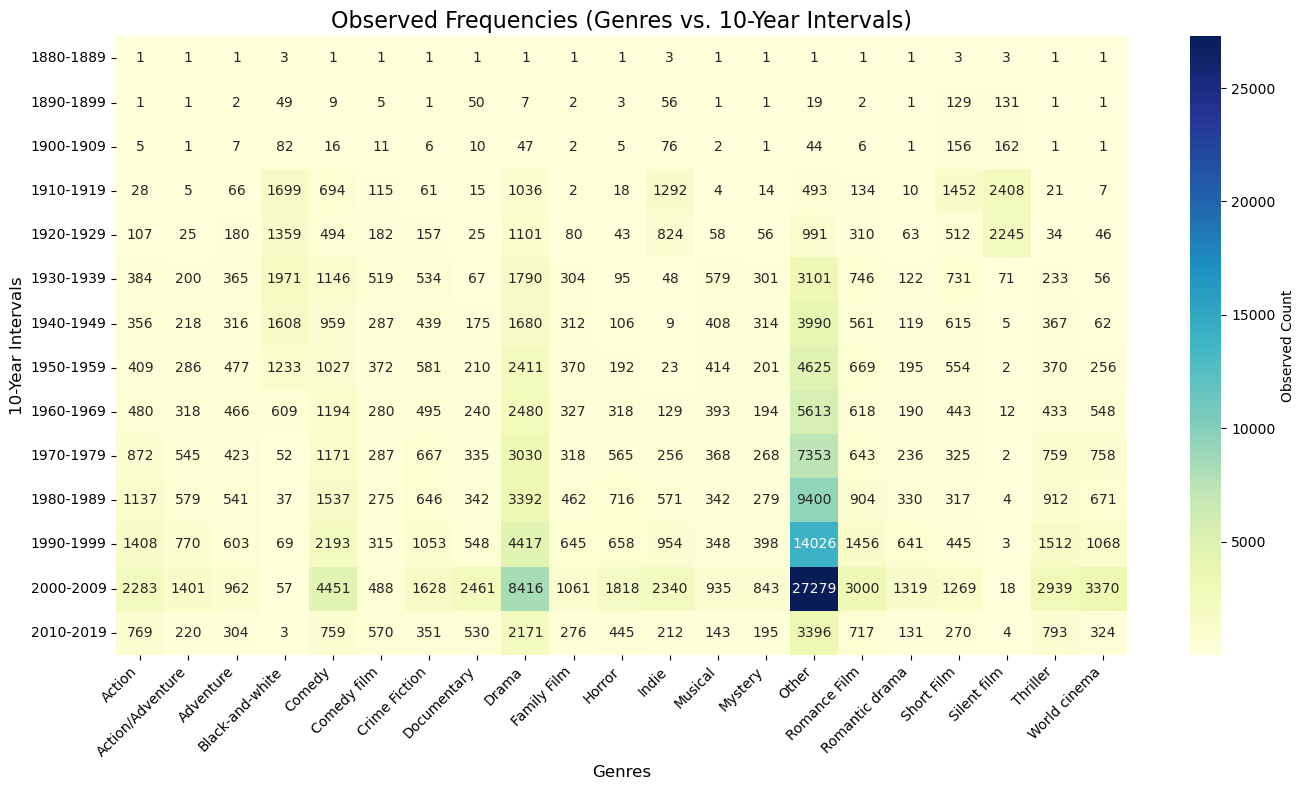

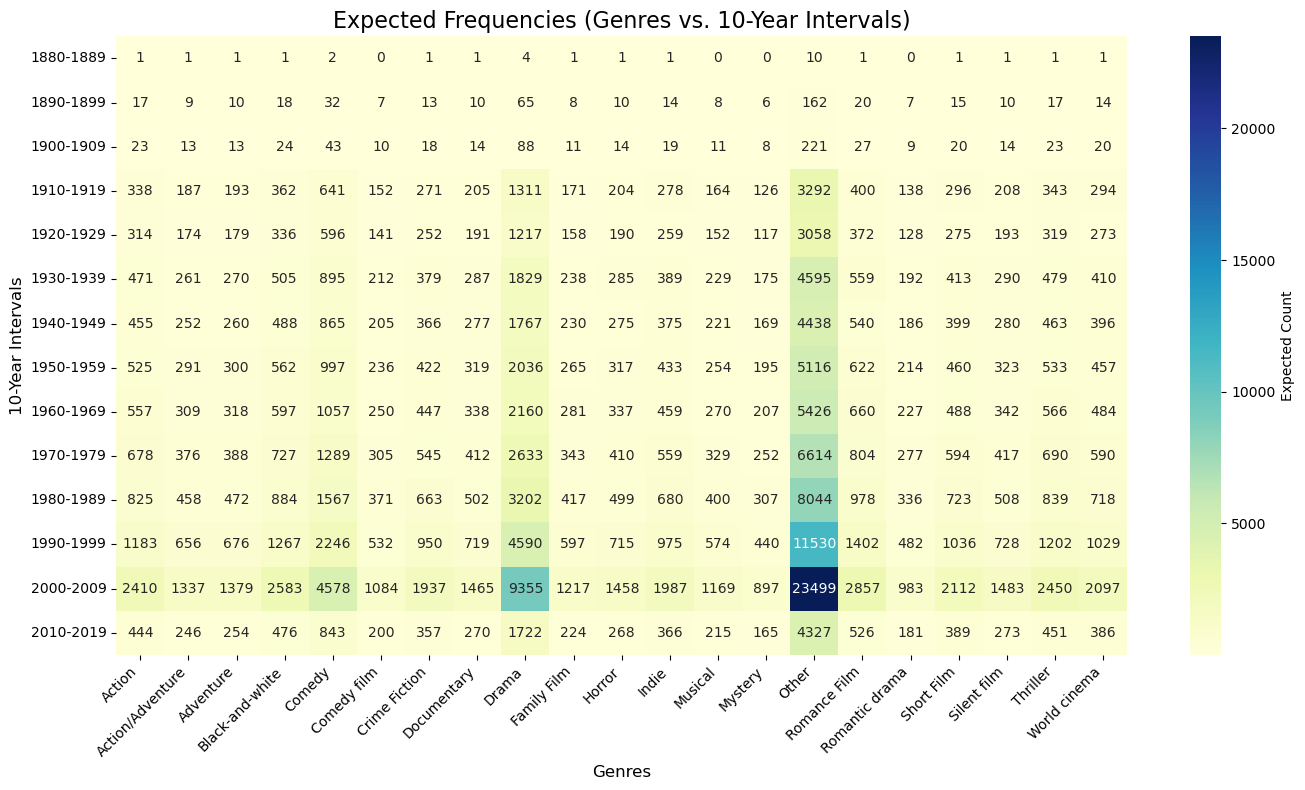

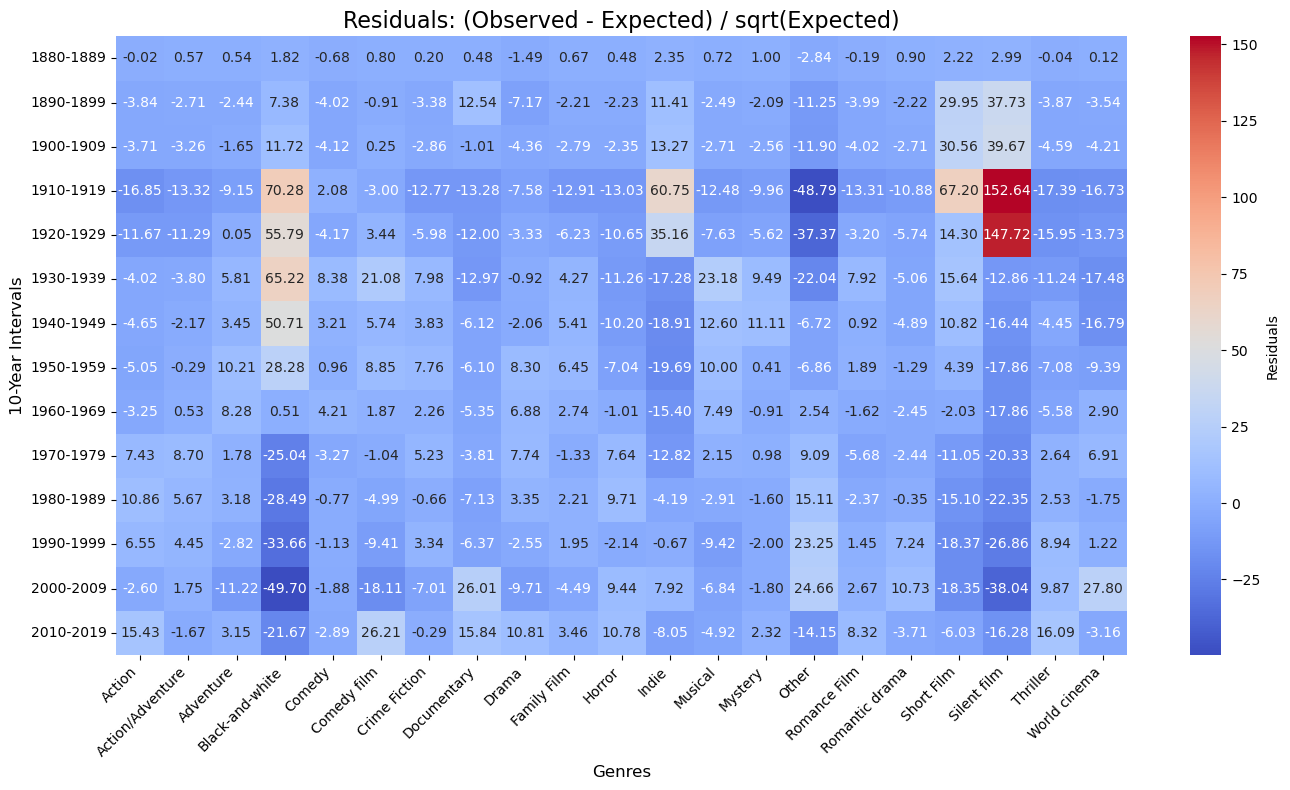

In [6]:
# Determine the minimum and maximum year in the dataset
year_min = movies_expanded['title_year'].min()
year_max = movies_expanded['title_year'].max()

# Create bins of 10-year intervals
bin_edges = np.arange(year_min - (year_min % 10), year_max + 10, 10)
bin_labels = [f"{start}-{end-1}" for start, end in zip(bin_edges[:-1], bin_edges[1:])]

# Assign each movie to a 10-year bin
movies_expanded['year_bin'] = pd.cut(movies_expanded['title_year'], bins=bin_edges, labels=bin_labels, right=False)

# Group by year_bin and genres
genre_counts = movies_expanded.groupby(['year_bin', 'genres']).size().unstack(fill_value=0)

# Calculate total movie counts per genre
total_genre_counts = genre_counts.sum(axis=0).sort_values(ascending=False)

# Select top N genres and group the rest as "Other"
top_n = 20  # Choose the number of top genres to keep
top_genres = total_genre_counts.head(top_n).index
movies_expanded['genres_reduced'] = movies_expanded['genres'].apply(
    lambda g: g if g in top_genres else "Other"
)

# Re-group data using reduced genres
genre_counts_reduced = movies_expanded.groupby(['year_bin', 'genres_reduced']).size().unstack(fill_value=0)

# Add a small constant to avoid zero frequencies
genre_counts_reduced += 1

# Calculate expected frequencies from the Chi-squared test
_, _, dof, expected = chi2_contingency(genre_counts_reduced)
expected_df = pd.DataFrame(expected, index=genre_counts_reduced.index, columns=genre_counts_reduced.columns)

# Calculate the residuals (observed - expected) / sqrt(expected)
residuals = (genre_counts_reduced - expected_df) / np.sqrt(expected_df)

plot_frequencies(genre_counts_reduced, expected_df, residuals)



##### Results :
We can observe small trends but nothing really interesting that we can't see with the other plots which are more clear.

## 1.2 Genre trend Analysis based on revenue


In [7]:
# Explode the genres column to split multiple genres into separate rows
movies_with_revenue['genres'] = movies_with_revenue['genres'].astype(str).str.split('|')
exploded_df = movies_with_revenue.explode('genres')

# Run the function
create_genre_revenue_plot(exploded_df)

Top 5 genres: ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance']
Filtered Worst 5 genres: ['Musical', 'Western', 'Documentary', 'Film-Noir', 'News']


/var/folders/kk/gkc7tsxj1ml1y68bbcxbj6440000gn/T/ipykernel_87336/267486140.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 1.3 Genre trend evolution based on imdb score

In [8]:
# Add a new column for split genres in the original DataFrame
movies_df['split_genre'] = movies_df['genres'].str.split('|')

df_exploded = movies_df.explode('split_genre')  # Explode the split_genre column

# Calculate the genre counts
genre_counts = df_exploded['split_genre'].value_counts()

# Create a reusable FigureWidget
fig_widget = go.FigureWidget()

# Define a function to update the existing plot
def update_genre_by_limit(count_limit):
    # Clear the figure
    fig_widget.data = []
    
    # Filter genres with counts greater than the count limit
    valid_genres = genre_counts[genre_counts > count_limit].index
    
    # Filter the exploded DataFrame for valid genres
    filtered_df = df_exploded[df_exploded['split_genre'].isin(valid_genres)]
    
    # Calculate the average IMDb scores for each valid genre
    average_scores = filtered_df.groupby('split_genre')['imdb_score'].mean().sort_values()
    
    # Update the plot
    fig_widget.add_trace(
        go.Bar(
            x=average_scores.index,
            y=average_scores.values,
            name='Genres',
            marker=dict(color='skyblue')
        )
    )
    
    # Update layout
    fig_widget.update_layout(
        title=f'Average IMDb Score per Genre',
        xaxis_title='Genres',
        yaxis_title='Average IMDb Score',
        xaxis=dict(categoryorder='total descending')
    )

# Use ipywidgets to create an interactive slider
interact(update_genre_by_limit, count_limit=IntSlider(min=100, max=1000, step=50, value=500, description='Min Count'))


fig_widget


interactive(children=(IntSlider(value=500, description='Min Count', max=1000, min=100, step=50), Output()), _d…

FigureWidget({
    'data': [{'marker': {'color': 'skyblue'},
              'name': 'Genres',
              'type': 'bar',
              'uid': 'b2563777-0e1f-4bee-8948-ce41401c50ae',
              'x': array(['Horror', 'Comedy', 'Action', 'Family', 'Sci-Fi', 'Fantasy', 'Thriller',
                          'Adventure', 'Romance', 'Crime', 'Drama'], dtype=object),
              'y': array([5.84353982, 6.19524573, 6.23989592, 6.24505495, 6.28181818, 6.30704918,
                          6.31424522, 6.4411701 , 6.45058717, 6.5647919 , 6.76376253])}],
    'layout': {'template': '...',
               'title': {'text': 'Average IMDb Score per Genre'},
               'xaxis': {'categoryorder': 'total descending', 'title': {'text': 'Genres'}},
               'yaxis': {'title': {'text': 'Average IMDb Score'}}}
})

In [9]:
# Extract the decade from the release year
df_exploded['title_year'] = pd.to_numeric(df_exploded['title_year'], errors='coerce')
df_exploded['decade'] = (df_exploded['title_year'] // 10 * 10).astype('Int64')

# Create a reusable FigureWidget
fig_widget = go.FigureWidget()

# Define a function to update the existing plot dynamically
def update_plot_genre_trend_imdb(count_limit):
    # Clear existing traces from the figure
    fig_widget.data = []
    
    # Calculate the genre counts for each decade
    genre_counts_by_decade = df_exploded.groupby(['decade', 'split_genre']).size()
    
    # Filter genres with counts greater than the count limit for each decade
    valid_genres_by_decade = genre_counts_by_decade[genre_counts_by_decade > count_limit].reset_index()
    valid_genres = valid_genres_by_decade['split_genre'].unique()
    
    # Filter the exploded DataFrame for valid genres
    filtered_df = df_exploded[df_exploded['split_genre'].isin(valid_genres)]
    
    # Calculate the average IMDb scores for each genre by decade
    average_scores_by_decade = (
        filtered_df.groupby(['decade', 'split_genre'])['imdb_score']
        .mean()
        .reset_index()
    )
    
    # Add traces dynamically for each genre
    for genre in valid_genres:
        genre_data = average_scores_by_decade[average_scores_by_decade['split_genre'] == genre]
        fig_widget.add_trace(
            go.Scatter(
                x=genre_data['decade'],
                y=genre_data['imdb_score'],
                mode='lines+markers',
                name=genre,
                marker=dict(size=8)
            )
        )
    
    # Update layout
    fig_widget.update_layout(
        title=f'Average IMDb Score by Genre Over Decades)',
        xaxis=dict(title='Decade'),
        yaxis=dict(title='Average IMDb Score'),
        legend=dict(title='Genres'),
        template='plotly_white'
    )

# Use ipywidgets to create an interactive slider
interact(update_plot_genre_trend_imdb, count_limit=IntSlider(min=100, max=1000, step=50, value=500, description='Min Count'))

# Display the widget
fig_widget


interactive(children=(IntSlider(value=500, description='Min Count', max=1000, min=100, step=50), Output()), _d…

FigureWidget({
    'data': [{'marker': {'size': 8},
              'mode': 'lines+markers',
              'name': 'Comedy',
              'type': 'scatter',
              'uid': '69c6788e-8109-405e-bf3d-e3ac2d05aede',
              'x': array([1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]),
              'y': array([7.85714286, 6.8       , 7.7       , 7.1       , 7.12592593, 6.51022727,
                          6.34036145, 5.99813302, 6.16812749])},
             {'marker': {'size': 8},
              'mode': 'lines+markers',
              'name': 'Drama',
              'type': 'scatter',
              'uid': '04cf05e7-f5b9-471e-9f5d-0dd01b516fec',
              'x': array([1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]),
              'y': array([8.        , 7.35      , 7.63333333, 7.48823529, 7.43333333, 7.52325581,
                          7.41886792, 6.95585586, 6.81470588, 6.71449407, 6.52777778])},
             {'marker': {'size': 8},
              'mode

In [10]:
# Extract the decade from the release year
df_exploded['title_year'] = pd.to_numeric(df_exploded['title_year'], errors='coerce')
df_exploded['decade'] = (df_exploded['title_year'] // 10 * 10).astype('Int64')

# Create a reusable FigureWidget
fig_widget = go.FigureWidget()

# Define a function to update the plot and add statistical analysis
def update_plot_genre_trend_imdb_Rsqrd(count_limit):
    # Clear existing traces from the figure
    fig_widget.data = []
    
    # Calculate the genre counts for each decade
    genre_counts_by_decade = df_exploded.groupby(['decade', 'split_genre']).size()
    
    # Filter genres with counts greater than the count limit for each decade
    valid_genres_by_decade = genre_counts_by_decade[genre_counts_by_decade > count_limit].reset_index()
    valid_genres = valid_genres_by_decade['split_genre'].unique()
    
    # Filter the exploded DataFrame for valid genres
    filtered_df = df_exploded[df_exploded['split_genre'].isin(valid_genres)]
    
    # Calculate the average IMDb scores for each genre by decade
    average_scores_by_decade = (
        filtered_df.groupby(['decade', 'split_genre'])['imdb_score']
        .mean()
        .reset_index()
    )
    
    # Add traces dynamically for each genre
    for genre in valid_genres:
        genre_data = average_scores_by_decade[average_scores_by_decade['split_genre'] == genre]
        
        # Add scatter trace for the genre
        fig_widget.add_trace(
            go.Scatter(
                x=genre_data['decade'],
                y=genre_data['imdb_score'],
                mode='lines+markers',
                name=genre,
                marker=dict(size=8)
            )
        )
        
        # Perform linear regression for the trend line
        slope, intercept, r_value, p_value, std_err = linregress(
            genre_data['decade'], genre_data['imdb_score']
        )
        
        # Generate regression line
        regression_line = slope * genre_data['decade'] + intercept
        
        # Add regression trace
        fig_widget.add_trace(
            go.Scatter(
                x=genre_data['decade'],
                y=regression_line,
                mode='lines',
                name=f"{genre} Trend (R²={r_value**2:.2f})",
                line=dict(dash='dot'),
                hoverinfo='none'
            )
        )

    # Update layout
    fig_widget.update_layout(
        title=f'Average IMDb Score by Genre Over Decades (Count > {count_limit})',
        xaxis=dict(title='Decade'),
        yaxis=dict(title='Average IMDb Score'),
        legend=dict(title='Genres'),
        template='plotly_white'
    )

# Use ipywidgets to create an interactive slider
interact(update_plot_genre_trend_imdb_Rsqrd, count_limit=IntSlider(min=100, max=1000, step=50, value=500, description='Min Count'))

# Display the widget
fig_widget


interactive(children=(IntSlider(value=500, description='Min Count', max=1000, min=100, step=50), Output()), _d…

FigureWidget({
    'data': [{'marker': {'size': 8},
              'mode': 'lines+markers',
              'name': 'Comedy',
              'type': 'scatter',
              'uid': 'a31a9822-f3de-4b4f-b480-4a0393a533a6',
              'x': array([1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]),
              'y': array([7.85714286, 6.8       , 7.7       , 7.1       , 7.12592593, 6.51022727,
                          6.34036145, 5.99813302, 6.16812749])},
             {'hoverinfo': 'none',
              'line': {'dash': 'dot'},
              'mode': 'lines',
              'name': 'Comedy Trend (R²=0.75)',
              'type': 'scatter',
              'uid': 'b8eb988c-31cd-4973-b855-8407f980b58c',
              'x': array([1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]),
              'y': array([7.67581615, 7.46797095, 7.26012574, 7.05228054, 6.84443533, 6.63659013,
                          6.42874493, 6.22089972, 6.01305452])},
             {'marker': {'size': 8},
         

# Actor Pairs and Directors Analysis : PART 2 of our data story 

This part contains a series of analyses performed on two datasets related to movies and awards. The analyses include trends over time, correlations, and visual insights.

### Datasets:
1. **Movies Dataset**: Contains information about movies, such as title, director, genres, IMDb scores, and user reviews.
2. **Awards Dataset**: Contains information about awards, including categories, winners, and films.

Each analysis is implemented in its own section for clarity.

 - 1. Diversity in genres of movies featuring specific actor pairs.
 - 2. Oscar Data trend analysis
 - 3. Star power Analysis




## 2.1 this first study take a look at top actor pairs based on 2 metrics , diversity score and imdb rating.



In [11]:


# Calculate diversity scores by genre
actor_pairs_by_genre_diversity_score = calculate_diversity_score_by_genre(movies_df)

# Interactive plot for top 10 actor pairs per genre
def plot_diversity_scores(genre):
    # Filter data for the selected genre
    genre_data = actor_pairs_by_genre_diversity_score[actor_pairs_by_genre_diversity_score['genre'] == genre]
    top_pairs = genre_data.sort_values(by='diversity_score', ascending=False).head(10)

    # Plot the top 10 actor pairs by diversity score
    plt.figure(figsize=(10, 6))
    plt.barh(
        y=top_pairs.apply(lambda x: f"{x['actor1']} & {x['actor2']}", axis=1), 
        width=top_pairs['diversity_score'], 
        color='skyblue'
    )
    plt.xlabel('Diversity Score')
    plt.ylabel('Actor Pairs')
    plt.title(f'Top 10 Actor Pairs by Genre Diversity Score ({genre})')
    plt.tight_layout()
    plt.show()

# Create a dropdown widget to select genres
available_genres = actor_pairs_by_genre_diversity_score['genre'].unique()
genre_widget = widgets.Dropdown(options=available_genres, description='Select Genre:')

# Display interactive plot
interact(plot_diversity_scores, genre=genre_widget)



interactive(children=(Dropdown(description='Select Genre:', options=('Action', 'Adventure', 'Fantasy', 'Sci-Fi…

<function __main__.plot_diversity_scores(genre)>

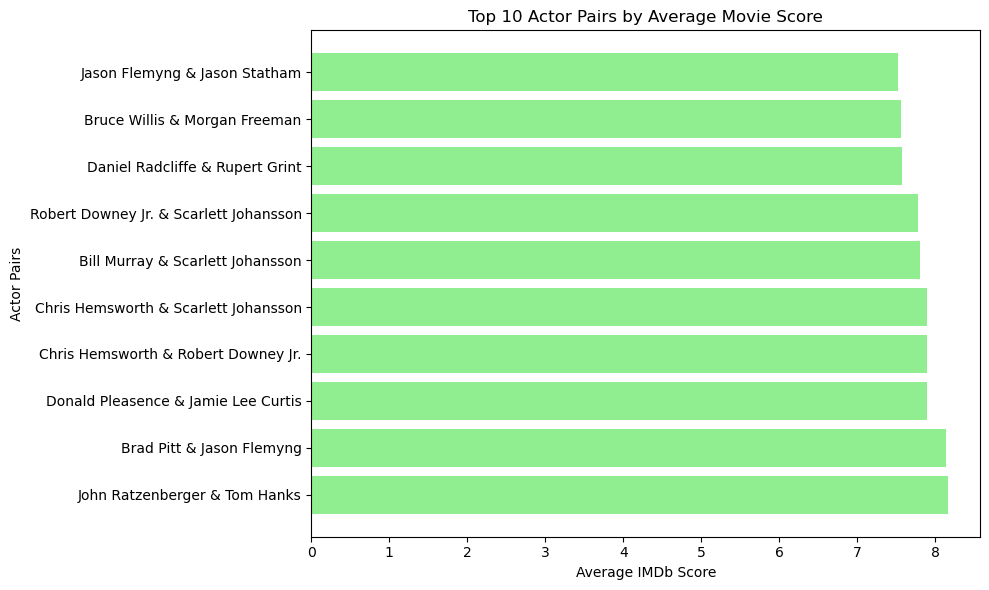

In [ ]:
# Create a dropdown widget to select genres for filtering
genre_filter_widget = widgets.SelectMultiple(options=available_genres, description='Filter Genres:')

# Display interactive plot with genre filtering
interact(plot_top_actor_pairs_by_score_with_genre(movies_df), genre_filter=genre_filter_widget)

In [13]:
# Run the combined analysis
combined_data = analyze_combined_scores(movies_df)

Correlation between Diversity Score and Average IMDb Score: 0.003


Output()

interactive(children=(Dropdown(description='Genre:', options=('Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'Thr…

In [14]:
# Widgets for interactivity
available_genres = movies_df['genres'].str.split('|').explode().unique()
available_decades = sorted((movies_df['title_year'] // 10 * 10).dropna().unique().astype(int))

# Interactive heatmap widget
heatmap_genre_widget = widgets.SelectMultiple(options=available_genres, description="Filter Genres:")
heatmap_decade_widget = widgets.Dropdown(options=available_decades, description="Filter Decade:")
interact(
    lambda genre_filter, decade_filter: plot_actor_pair_heatmap(movies_df, genre_filter=list(genre_filter), decade_filter=decade_filter),
    genre_filter=heatmap_genre_widget,
    decade_filter=heatmap_decade_widget
)


interactive(children=(SelectMultiple(description='Filter Genres:', options=('Action', 'Adventure', 'Fantasy', …

<function __main__.<lambda>(genre_filter, decade_filter)>

In [15]:
# Call the function to plot the 3D visualization
plot_3d_collaboration_scores(movies_df)


In [16]:
# Call the function to plot the 3D surface visualization
plot_3d_surface_collaboration_scores(movies_df)

## 2.2 Analysis on Oscars is made in the P2 section of the oscar awards.


## 2.3 Star Power 

In [17]:

# Compute the average nominations per category
average_nominations_per_category = awards_df.groupby('category').size().reset_index(name='nomination_count')
filtered_categories = (
    average_nominations_per_category
    .sort_values(by='nomination_count', ascending=False)
    .head(20)
    ['category']
)

# Create a dropdown widget for selecting filter type
filter_type = widgets.Dropdown(
    options=filtered_categories.tolist(),  # Use only filtered categories
    value=filtered_categories.iloc[0] if not filtered_categories.empty else None,  # Default to first filtered category
    description='Filter by:',
    disabled=False,
)

# Function to update the plot based on the selected filter
def update_plot_nominations_oscar(filter_type):
    if filter_type is None:
        print("No categories meet the criteria of average nominations > 4.")
        return
    
    filtered_nominations = awards_df[awards_df['category'] == filter_type]
    nominations_per_name = filtered_nominations.groupby('name').size().sort_values(ascending=False).head(10)
    
    if nominations_per_name.empty:  # Check if the data is empty
        print(f"No data available for category: {filter_type}.")
        return
    
    plt.figure(figsize=(12, 8))
    nominations_per_name.plot(kind='bar', color='lightblue')
    plt.title(f"Top 10 Most-Nominated in Category: {filter_type}", fontsize=16)
    plt.xlabel('Name', fontsize=14)
    plt.ylabel('Number of Nominations', fontsize=14)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Interactive plot with dropdown
interactive_plot = widgets.interactive(update_plot_nominations_oscar, filter_type=filter_type)
display(interactive_plot)

interactive(children=(Dropdown(description='Filter by:', options=('DIRECTING', 'FILM EDITING', 'ACTOR IN A SUP…

In [18]:
# Implement the analysis steps
star_power_df = calculate_star_power(movies_df, awards_df)
producer_metrics = calculate_producer_metrics(movies_df)
actor_producer_df = merge_actor_producer_data(movies_df, star_power_df, producer_metrics)

# Analyze correlation
print("Correlation between Actor Star Power and Producer Index:")
print(actor_producer_df[['star_power_index', 'producer_index']].corr())

# Visualize Actor-Producer relationship
plot_actor_producer_relationship(actor_producer_df)

# Visualize trends over time
plot_trends_over_time(actor_producer_df, movies_df)


Correlation between Actor Star Power and Producer Index:
                  star_power_index  producer_index
star_power_index          1.000000        0.304573
producer_index            0.304573        1.000000
